# Cas Kaggle: Brewer's Friend Beer Recipes

In [53]:
from sklearn.datasets import make_regression
import numpy as np
import pandas as pd
%matplotlib notebook
from matplotlib import pyplot as plt
import scipy.stats
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import Normalizer
from sklearn.preprocessing import LabelEncoder

from sklearn import linear_model, svm, datasets, neighbors, tree, naive_bayes
from sklearn.model_selection import train_test_split, cross_validate, GridSearchCV, RandomizedSearchCV, LeaveOneOut
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import f1_score, recall_score, precision_recall_curve, average_precision_score, roc_curve, auc
from sklearn.ensemble import RandomForestClassifier, BaggingClassifier, GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier
from scipy.stats import uniform

In [2]:
def load_dataset(path):
    dataset = pd.read_csv(path, header=0, delimiter=',', encoding='latin-1')
    return dataset

In [3]:
dataset = load_dataset('recipeData.csv')
data = dataset.values

**EDA**

In [4]:
#Visualització d'algunes de les dades
dataset.head

<bound method NDFrame.head of        BeerID                             Name  \
0           1                Vanilla Cream Ale   
1           2      Southern Tier Pumking clone   
2           3      Zombie Dust Clone - EXTRACT   
3           4    Zombie Dust Clone - ALL GRAIN   
4           5  Bakke Brygg Belgisk Blonde 50 l   
...       ...                              ...   
73856   73857                    Amber Alfie 2   
73857   73858                          Rye IPA   
73858   73859                        SK-Kölsch   
73859   73860                  Flata Rødkløver   
73860   73861            Elvis Juice IPA Clone   

                                                     URL  \
0           /homebrew/recipe/view/1633/vanilla-cream-ale   
1      /homebrew/recipe/view/16367/southern-tier-pumk...   
2      /homebrew/recipe/view/5920/zombie-dust-clone-e...   
3      /homebrew/recipe/view/5916/zombie-dust-clone-a...   
4      /homebrew/recipe/view/89534/bakke-brygg-belgis...   
...      

In [5]:
#Visualització del tipus de dades
dataset.dtypes

BeerID             int64
Name              object
URL               object
Style             object
StyleID            int64
Size(L)          float64
OG               float64
FG               float64
ABV              float64
IBU              float64
Color            float64
BoilSize         float64
BoilTime           int64
BoilGravity      float64
Efficiency       float64
MashThickness    float64
SugarScale        object
BrewMethod        object
PitchRate        float64
PrimaryTemp      float64
PrimingMethod     object
PrimingAmount     object
UserId           float64
dtype: object

In [6]:
#Visualització dels atributs
dataset.columns

Index(['BeerID', 'Name', 'URL', 'Style', 'StyleID', 'Size(L)', 'OG', 'FG',
       'ABV', 'IBU', 'Color', 'BoilSize', 'BoilTime', 'BoilGravity',
       'Efficiency', 'MashThickness', 'SugarScale', 'BrewMethod', 'PitchRate',
       'PrimaryTemp', 'PrimingMethod', 'PrimingAmount', 'UserId'],
      dtype='object')

In [7]:
#Elimino l'atribut URL ja que no em serveix per a l'estudi
df=dataset.drop('URL',axis=1)

In [8]:
#Elimino l'atribut Name del dataset a estudiar ja que tinc l'Atribut BeerID que en fa referència, el mateix amb Style i StyleID
style_names=df['Style']
df=df.drop('Name',axis=1)
#df=df.drop('Style',axis=1)

In [9]:
#Anem a mirar quants valors tenim no existents:
print(df.isnull().sum())

BeerID               0
Style              596
StyleID              0
Size(L)              0
OG                   0
FG                   0
ABV                  0
IBU                  0
Color                0
BoilSize             0
BoilTime             0
BoilGravity       2990
Efficiency           0
MashThickness    29864
SugarScale           0
BrewMethod           0
PitchRate        39252
PrimaryTemp      22662
PrimingMethod    67095
PrimingAmount    69087
UserId           50490
dtype: int64


In [10]:
#Elimino els atributs als que el falta més de la meitat de les dades:
for col in df.columns:
    if df[col].isnull().sum()>=(df.shape[0]/2):
        df=df.drop(col,axis=1)

In [11]:
#Omplo els tipus de cervesa que no estan especificats:
df['Style'].fillna('Unknown', inplace=True)

In [12]:
#Comprovació de com em queden les dades:
print(df.isnull().sum())

BeerID               0
Style                0
StyleID              0
Size(L)              0
OG                   0
FG                   0
ABV                  0
IBU                  0
Color                0
BoilSize             0
BoilTime             0
BoilGravity       2990
Efficiency           0
MashThickness    29864
SugarScale           0
BrewMethod           0
PrimaryTemp      22662
dtype: int64


In [13]:
#Cal tractar els atributs objecte per tal de poder treballar amb ells
df.dtypes

BeerID             int64
Style             object
StyleID            int64
Size(L)          float64
OG               float64
FG               float64
ABV              float64
IBU              float64
Color            float64
BoilSize         float64
BoilTime           int64
BoilGravity      float64
Efficiency       float64
MashThickness    float64
SugarScale        object
BrewMethod        object
PrimaryTemp      float64
dtype: object

In [14]:
#Transformaré les dades que són del tipus 'object' amb la funció get_dummies
df['SugarScale'].unique()
df = pd.get_dummies(df, columns=['SugarScale', 'BrewMethod'])
columns=df.columns

In [15]:
columns

Index(['BeerID', 'Style', 'StyleID', 'Size(L)', 'OG', 'FG', 'ABV', 'IBU',
       'Color', 'BoilSize', 'BoilTime', 'BoilGravity', 'Efficiency',
       'MashThickness', 'PrimaryTemp', 'SugarScale_Plato',
       'SugarScale_Specific Gravity', 'BrewMethod_All Grain',
       'BrewMethod_BIAB', 'BrewMethod_Partial Mash', 'BrewMethod_extract'],
      dtype='object')

<IPython.core.display.Javascript object>


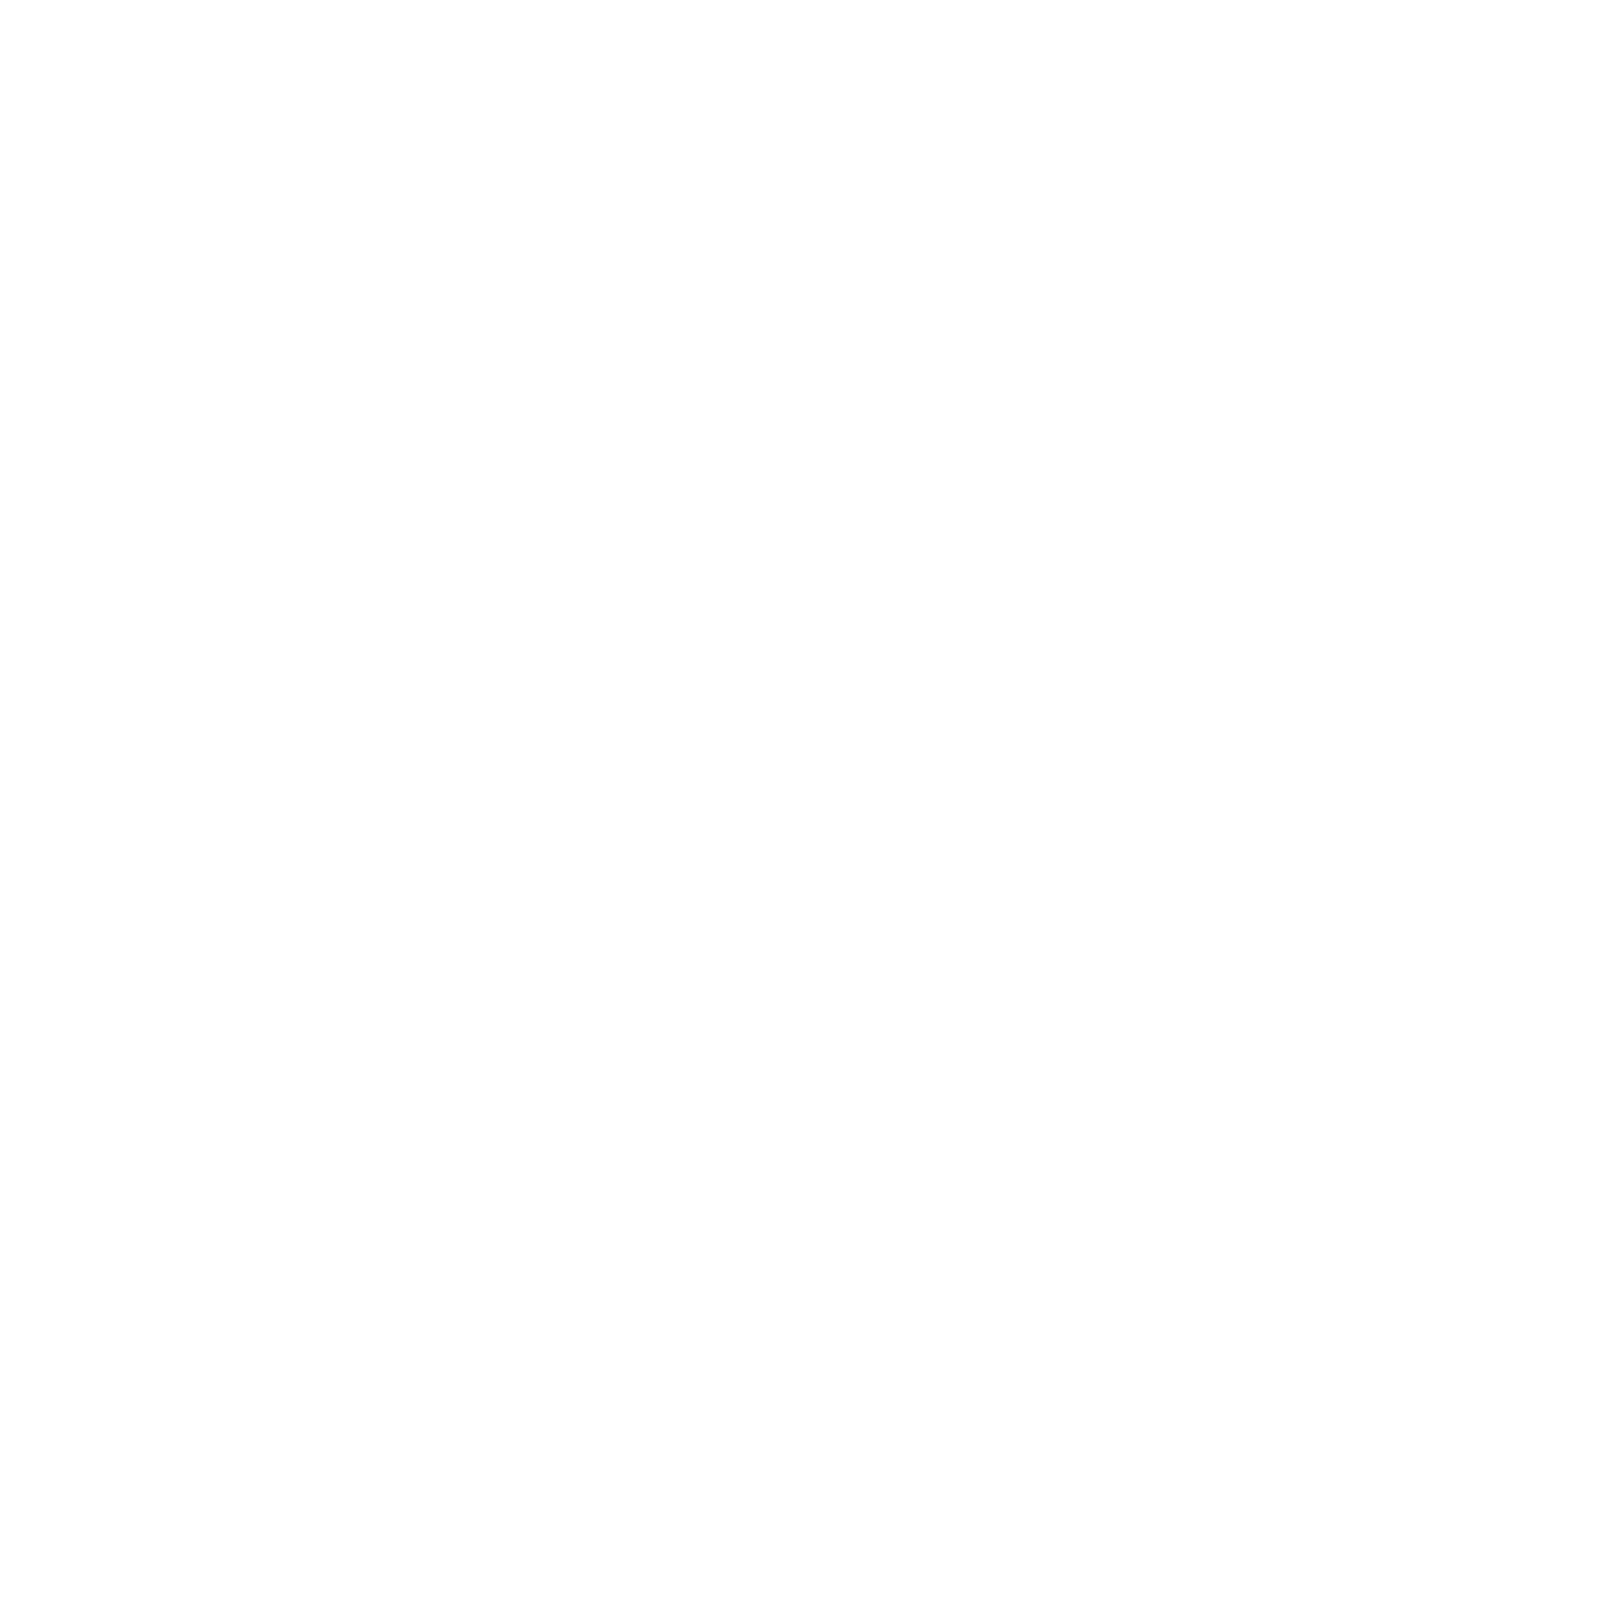

In [16]:
#Mirem la correlació entre les dades com que tinc molts atributs miraré les correlacions 
correlacio = df.corr()
plt.figure(figsize=(15, 15), dpi=80)
ax = sns.heatmap(correlacio, annot=True, linewidths=.5)

In [17]:
#Visualització de les dades:
#relacio = sns.pairplot(df)

In [18]:
#tractem els nans que ens queden
#Com que els atributs que tenen Nan's son floats, utilitzaré la tècnica de omplir els Nans amb 
#les mitjanes per tal d'omplir els valors
df.fillna(df.mean(), inplace=True)
print(df.isnull().sum())

BeerID                         0
Style                          0
StyleID                        0
Size(L)                        0
OG                             0
FG                             0
ABV                            0
IBU                            0
Color                          0
BoilSize                       0
BoilTime                       0
BoilGravity                    0
Efficiency                     0
MashThickness                  0
PrimaryTemp                    0
SugarScale_Plato               0
SugarScale_Specific Gravity    0
BrewMethod_All Grain           0
BrewMethod_BIAB                0
BrewMethod_Partial Mash        0
BrewMethod_extract             0
dtype: int64


In [19]:
#Mirem les distribucions de les dades
for col in columns:
    print(df[col].value_counts())
#En general les dades estan molt mal distribuïdes

2049     1
42494    1
1386     1
7529     1
5480     1
        ..
25241    1
27288    1
4759     1
6806     1
2047     1
Name: BeerID, Length: 73861, dtype: int64
American IPA              11940
American Pale Ale          7581
Saison                     2617
American Light Lager       2277
American Amber Ale         2038
                          ...  
Lichtenhainer                 6
Apple Wine                    6
Pyment (Grape Melomel)        5
Traditional Perry             2
French Cider                  2
Name: Style, Length: 176, dtype: int64
7      11940
10      7581
134     2617
9       2277
4       2038
       ...  
16         6
99         6
127        5
73         2
164        2
Name: StyleID, Length: 176, dtype: int64
20.82      16714
18.93       9994
22.71       3459
21.00       3020
20.00       2628
           ...  
182.84         1
39.07          1
41.80          1
29.75          1
3350.00        1
Name: Size(L), Length: 1065, dtype: int64
1.0520     2932
1.0500     2795
1

In [20]:
df.dtypes

BeerID                           int64
Style                           object
StyleID                          int64
Size(L)                        float64
OG                             float64
FG                             float64
ABV                            float64
IBU                            float64
Color                          float64
BoilSize                       float64
BoilTime                         int64
BoilGravity                    float64
Efficiency                     float64
MashThickness                  float64
PrimaryTemp                    float64
SugarScale_Plato                 uint8
SugarScale_Specific Gravity      uint8
BrewMethod_All Grain             uint8
BrewMethod_BIAB                  uint8
BrewMethod_Partial Mash          uint8
BrewMethod_extract               uint8
dtype: object

In [21]:
#Veient les dades que em dona seria interessant intentar predir quin tipus d'elaboració de cervesa és segons les seves característiques
#Tinc molts estils de cerveses i la distribució de les dades és molt poc equil·librada.
len(df['StyleID'].unique())

176

In [22]:
#Podem visualitzar les 20 més comunes per veure la distribució aproximadament
types = 20
most_common = df['Style'].value_counts()[:types]
most_common

American IPA              11940
American Pale Ale          7581
Saison                     2617
American Light Lager       2277
American Amber Ale         2038
Blonde Ale                 1753
Imperial IPA               1478
American Stout             1268
Irish Red Ale              1204
American Brown Ale         1152
Witbier                    1072
California Common Beer     1044
Weissbier                   988
Oatmeal Stout               961
Russian Imperial Stout      929
Weizen/Weissbier            919
Sweet Stout                 919
Robust Porter               897
Kölsch                      869
Double IPA                  864
Name: Style, dtype: int64

In [23]:
#Veiem que hi ha moltes classes que són específiques, per reduir el número podriem generalitzar amb les que són més comunes i 
#agrupar les que ens quedin en una classe "Other"
general_styles = ['Ale', 'IPA', 'Pale Ale', 'Lager', 'Stout', 'Bitter', 'Cider', 'Porter']
df['GeneralStyle'] = 'Other'
for general_style in general_styles:
    df.loc[df['Style'].str.contains(general_style), 'GeneralStyle'] = general_style
df['GeneralStyle']

0          Ale
1        Other
2          IPA
3          IPA
4          Ale
         ...  
73856      Ale
73857      IPA
73858    Other
73859      Ale
73860      IPA
Name: GeneralStyle, Length: 73861, dtype: object

In [24]:
#Creem el GeneralStyleID que segueixi aquest nou atribut
le = LabelEncoder()
le.fit(df.GeneralStyle)
df['GeneralStyleID'] = le.transform(df.GeneralStyle)

In [25]:
#Les correlacions són més altes que abans amb l'atribut 'StyleID'
TARGET='GeneralStyleID'
columns=df.columns
#representacio de tots els atributs amb mes correlacio
correlations_targ = df.corr()[TARGET].abs().sort_values(ascending=False)
correlations_targ

GeneralStyleID                 1.000000
Color                          0.350645
StyleID                        0.199478
IBU                            0.040227
ABV                            0.039194
PrimaryTemp                    0.026477
FG                             0.018307
BoilTime                       0.013507
BoilGravity                    0.013351
OG                             0.012295
SugarScale_Specific Gravity    0.009179
SugarScale_Plato               0.009179
BrewMethod_Partial Mash        0.008257
BrewMethod_BIAB                0.007876
BrewMethod_All Grain           0.007702
BoilSize                       0.005055
Size(L)                        0.004941
MashThickness                  0.004711
BeerID                         0.004207
BrewMethod_extract             0.003281
Efficiency                     0.000118
Name: GeneralStyleID, dtype: float64

<IPython.core.display.Javascript object>


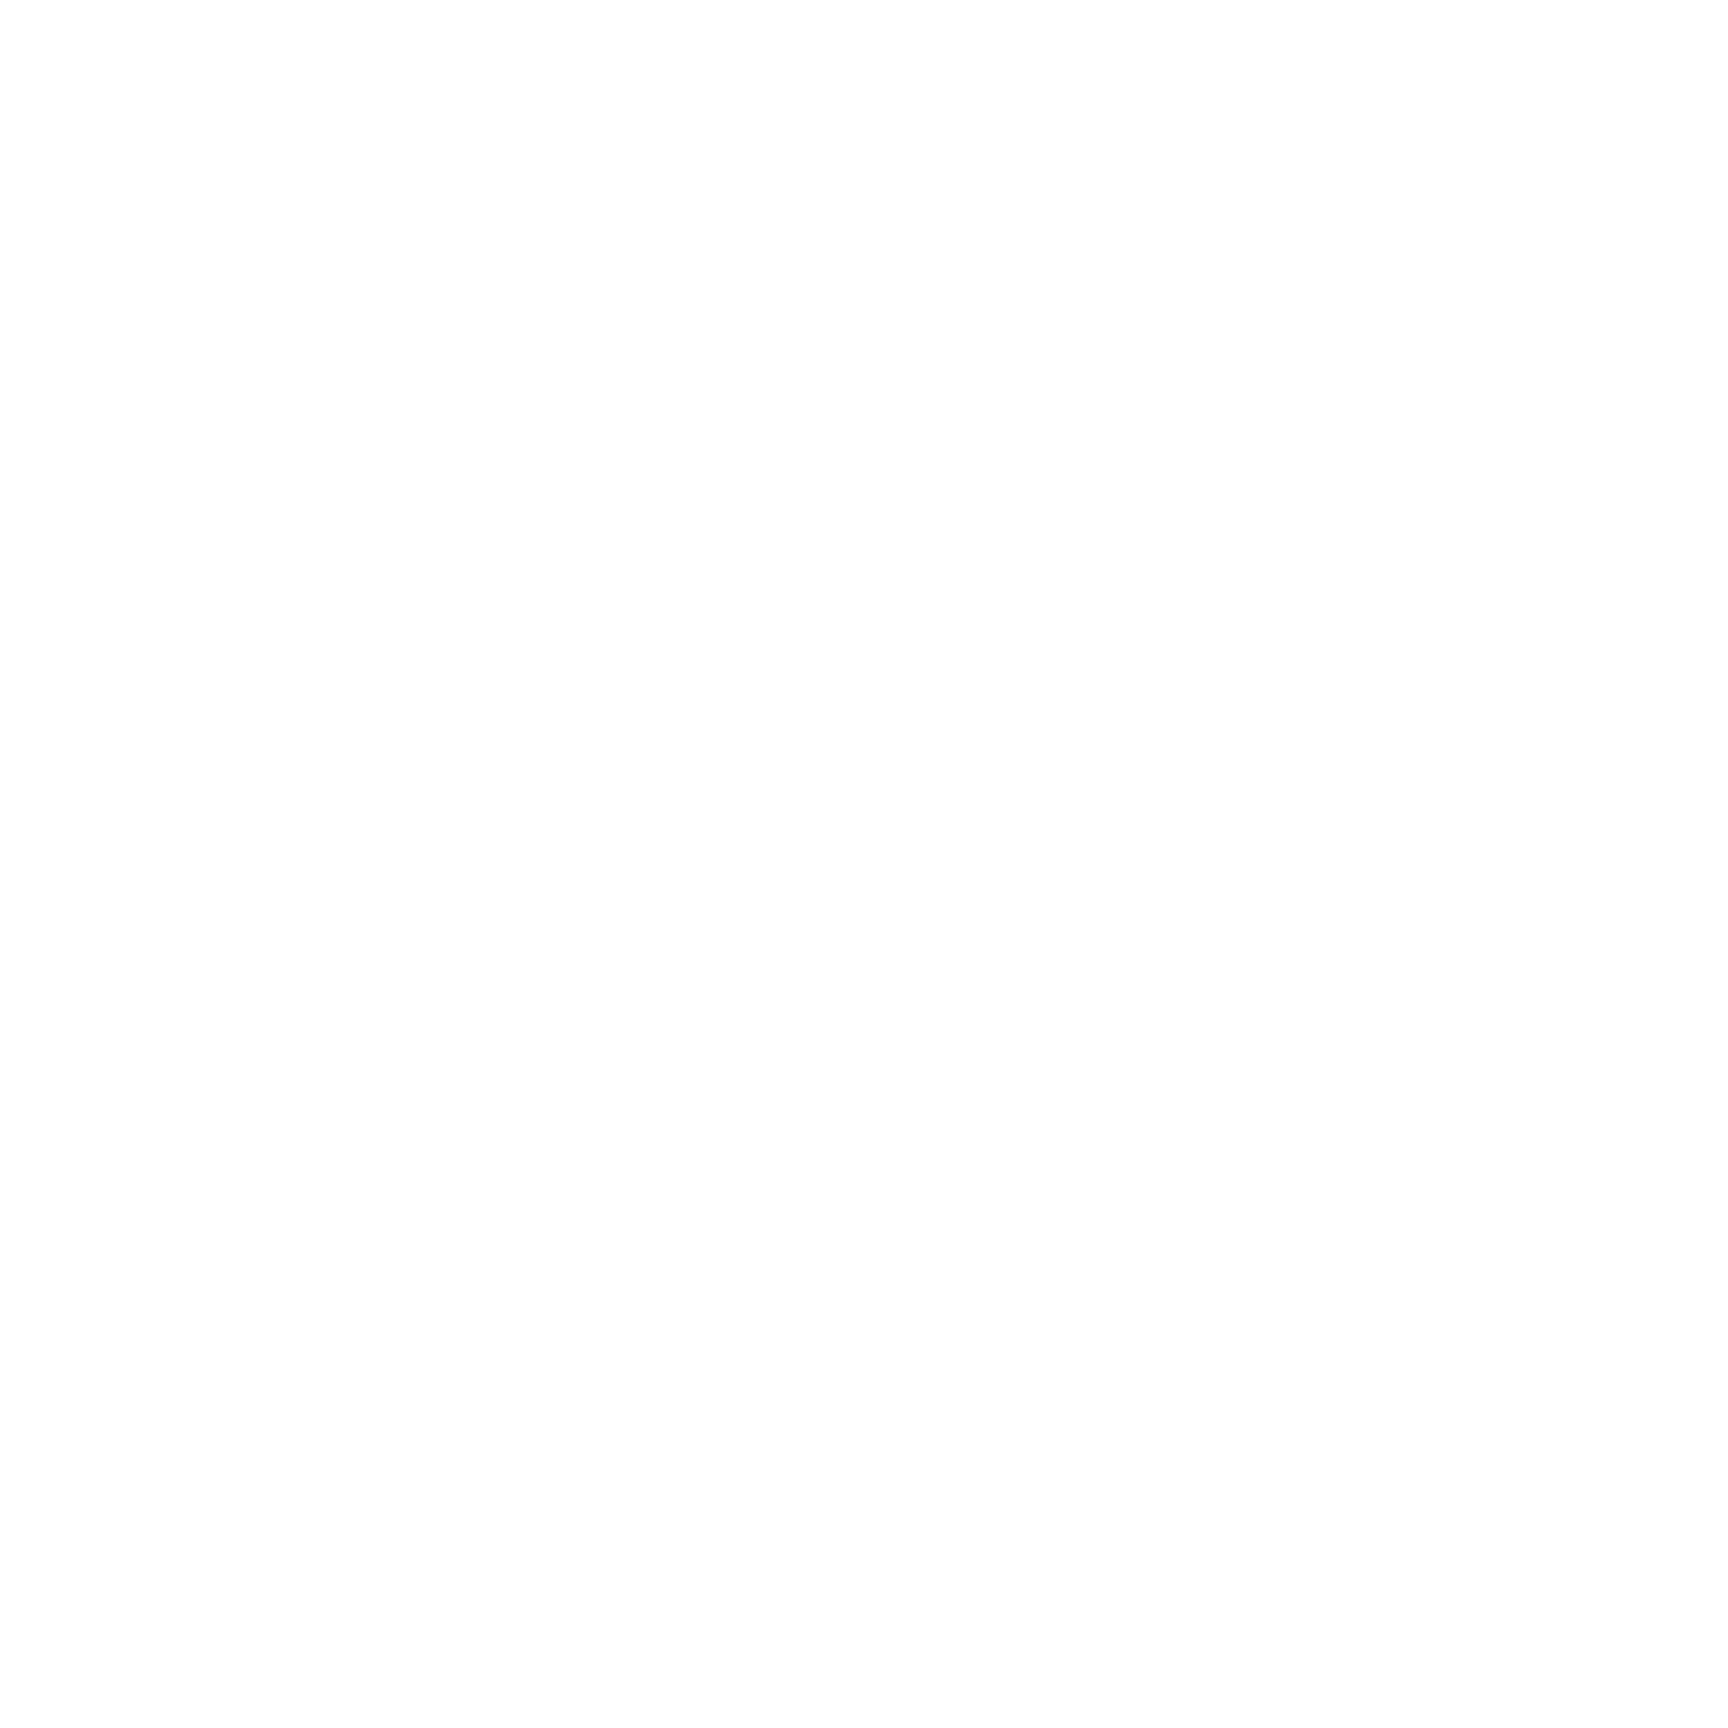

<AxesSubplot:>

In [26]:
#Veiem representades les correlacions
plt.figure(figsize=(16, 16), dpi=80)
sns.heatmap(df.corr(), annot=True)

In [27]:
#Mirem si les dades estan normalitzades
for col in df.select_dtypes(exclude='object'):
    _, pvalue = scipy.stats.normaltest(df[col])
    if pvalue > 1e-3:
        print(col)

In [28]:
#Veient les dades que em dona seria interessant intentar predir quin tipus d'elaboració de cervesa és segons les seves característiques
#Les nostres dades no estàn normalitzades i estàn en escales molt diferents, com que tenim molts atributs categòrics podem intentar 
#escalar i prou
#Podem crear també un dataset amb dades normalitzades per si de cas

In [29]:
#Per poder seguir fent el preprocessing eliminem les dades que són object
generalstyle_names=df['GeneralStyle']
df=df.drop(['Style', 'GeneralStyle'],axis=1)

In [40]:
most_common = df['GeneralStyleID'].value_counts()
most_common

5    22502
3    17064
0    10653
6     8206
8     5954
4     4110
7     2700
1     2481
2      191
Name: GeneralStyleID, dtype: int64

**MODEL SELECTION**

In [100]:
classifiers = {
    'LogisticRegression': LogisticRegression(max_iter=5000),
    'SGDClassifier': linear_model.SGDClassifier(loss="modified_huber", alpha=0.1),
    'KNeighborsClassifier': neighbors.KNeighborsClassifier(n_neighbors=15),
    'DecisionTreeClassifier': tree.DecisionTreeClassifier(),
    'GaussianNB': naive_bayes.GaussianNB(),
    'RandomForest': RandomForestClassifier(n_estimators=10)
}

In [97]:
#Escollint com a atribut objectiu Style
TARGET='StyleID'
y=df[TARGET]
X=df.drop(columns=TARGET)
X_esc=X.copy(deep=True)
X_esc = pd.DataFrame(
    MinMaxScaler().fit_transform(X),
    columns=X_esc.columns
)
X_norm=X.copy(deep=True)
X_norm = pd.DataFrame(
    Normalizer().fit(X_norm).transform(X_norm),  
    columns=X_norm.columns
)

Xs = {
    'original': X,
    'escalat': X_esc,
    #'normalitzat': X_norm
}

In [98]:
scores_ls = []
confusion_matrix_ls = []
for tipus_df, X_df in Xs.items():
    #print(tipus_df)
    scores = {name: [] for name in classifiers}
    cms = {name: [] for name in classifiers}
    #for it in range(5):
    X_train, X_test, y_train, y_test = train_test_split(X_df, y, test_size=0.2)
    for name, clf in classifiers.items():
        #print(name)
        clf.fit(X_train, y_train)
        y_pred = clf.predict(X_test)
        score = clf.score(X_test, y_test)
        #print(score)
        scores[name]=score

        #if it == 1:
        cm = confusion_matrix(y_test, y_pred)
        cms[name] = cm.ravel()
#         disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=clf.classes_)
#         disp.plot()
#         plt.title(f'Matriu de confusió amb el classificador {name}')
#         plt.show()

    
    scores = {name: score for name, score in scores.items()}
    scores_ls.append(scores)
    confusion_matrix_ls.append(cms)

pd.DataFrame(scores_ls, index=['Original','Escalat']).transpose()

D:\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


,Original,Escalat
LogisticRegression,0.197590,0.384621
SGDClassifier,0.095783,0.260137
KNeighborsClassifier,0.168280,0.459013
DecisionTreeClassifier,0.462668,0.463481
GaussianNB,0.240439,0.289244
RandomForest,0.537196,0.538956


In [101]:
#Escollint com a atribut objectiu GeneralStyles
TARGET='GeneralStyleID'
y=df[TARGET]
X=df.drop(columns=TARGET)
X_esc=X.copy(deep=True)
X_esc = pd.DataFrame(
    MinMaxScaler().fit_transform(X),
    columns=X_esc.columns
)
X_norm=X.copy(deep=True)
X_norm = pd.DataFrame(
    Normalizer().fit(X_norm).transform(X_norm),  
    columns=X_norm.columns
)

Xs = {
    'original': X,
    'escalat': X_esc,
    #'normalitzat': X_norm
}

In [96]:
scores_ls = []
confusion_matrix_ls = []
for tipus_df, X_df in Xs.items():
    #print(tipus_df)
    scores = {name: [] for name in classifiers}
    cms = {name: [] for name in classifiers}
    #for it in range(5):
    X_train, X_test, y_train, y_test = train_test_split(X_df, y, test_size=0.2)
    for name, clf in classifiers.items():
        #print(name)
        clf.fit(X_train, y_train)
        y_pred = clf.predict(X_test)
        score = clf.score(X_test, y_test)
        #print(score)
        scores[name]=score

        #if it == 1:
        cm = confusion_matrix(y_test, y_pred)
        cms[name] = cm.ravel()
#         disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=clf.classes_)
#         disp.plot()
#         plt.title(f'Matriu de confusió amb el classificador {name}')
#         plt.show()

    
    scores = {name: score for name, score in scores.items()}
    scores_ls.append(scores)
    confusion_matrix_ls.append(cms)

pd.DataFrame(scores_ls, index=['Original','Escalat']).transpose()

D:\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


,Original,Escalat
LogisticRegression,0.568402,0.548230
SGDClassifier,0.392608,0.403777
KNeighborsClassifier,0.452718,0.694510
DecisionTreeClassifier,0.991539,0.991065
GaussianNB,0.407162,0.332025
RandomForest,0.886482,0.887227


**HYPER PARAMETER SEARCH**

In [95]:
#Busquem millors paràmetres per al Regressor Logistic
params_ls=[]
for _ , X_df in Xs.items():
    logistic = LogisticRegression(solver='saga', tol=1e-2, max_iter=200, random_state=0)
    distributions = dict(C=uniform(loc=0, scale=4),penalty=['l2', 'l1'])
    clf = RandomizedSearchCV(logistic, distributions, random_state=0, n_iter=5)
    search = clf.fit(X_df, y)
    best=search.best_params_
    params = {name: param for name, param in best.items()}
    params_ls.append(params)
pd.DataFrame(params_ls, index=['Original','Escalat']).transpose()

,Original,Escalat
C,2.195254,2.179533
penalty,l1,l1


In [89]:
#Busquem els millors paràmetres per al DecisionTree
params_ls=[]
for _ , X_df in Xs.items():
    DT =tree.DecisionTreeClassifier()
    distributions = dict(criterion=['gini', 'entropy'])
    clf = RandomizedSearchCV(DT, distributions, random_state=0, n_iter=2)
    search = clf.fit(X_df, y)
    best=search.best_params_
    params = {name: param for name, param in best.items()}
    params_ls.append(params)
pd.DataFrame(params_ls, index=['Original','Escalat']).transpose()

,Original,Escalat
criterion,entropy,entropy


In [94]:
#Busquem els millors paràmetres per al RandomForest
params_ls=[]
for _ , X_df in Xs.items():
    RF =RandomForestClassifier()
    distributions = dict(n_estimators=[10, 50, 100], min_samples_leaf=[1, 2, 3])
    clf = RandomizedSearchCV(RF, distributions, random_state=0, n_iter=9)
    search = clf.fit(X_df, y)
    best=search.best_params_
    params = {name: param for name, param in best.items()}
    params_ls.append(params)
pd.DataFrame(params_ls, index=['Original','Escalat']).transpose()

,Original,Escalat
n_estimators,100,50
min_samples_leaf,1,2


**CROSS-VALIDATION**

In [103]:
scoring = ['precision_macro', 'recall_macro', 'f1_macro']
metrics = ['fit_time', 'score_time', 'test_precision_macro', 'test_recall_macro', 'test_f1_macro']
data = []

for name_df , X_df in Xs.items():
    scores = []
    #print(name_df)
    for name, clf in classifiers.items():
        #print(name)
        cv = cross_validate(clf, X_df, y, scoring=scoring, cv=5)
        cv = [ls.mean() for metric, ls in cv.items()]
        scores.append(cv)
    data.append(scores)

data = np.array(data)
# for i, metric in enumerate(metrics):
#     pd.DataFrame(
#         np.array([data[0, :, i], data[1, :, i]]).transpose(),
#         columns=['Original', 'Escalat'],
#         index=classifiers.keys()
#     ).plot.barh()
#     plt.title(metric)
#     plt.xlabel('metric')
for i, metric in enumerate(metrics):
    results=pd.DataFrame(
        np.array([data[0, :, i], data[1, :, i]]).transpose(),
        columns=['Original', 'Escalat'],
        index=classifiers.keys()
    )
    print(metric)
    print(results)
    print("\n")

D:\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
D:\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (

D:\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being

fit_time
                          Original    Escalat
LogisticRegression      217.829381  28.676050
SGDClassifier            22.399414   0.661889
KNeighborsClassifier      0.017952   0.014552
DecisionTreeClassifier    0.479029   0.469825
GaussianNB                0.043475   0.041895
RandomForest              1.204152   1.207935


score_time
                         Original    Escalat
LogisticRegression       0.028227   0.023936
SGDClassifier            0.022541   0.019723
KNeighborsClassifier    22.455955  18.976829
DecisionTreeClassifier   0.022740   0.021338
GaussianNB               0.048995   0.046977
RandomForest             0.059236   0.058377


test_precision_macro
                        Original   Escalat
LogisticRegression      0.344055  0.397862
SGDClassifier           0.188287  0.092180
KNeighborsClassifier    0.015531  0.419873
DecisionTreeClassifier  0.926234  0.933214
GaussianNB              0.378811  0.375206
RandomForest            0.806952  0.799723


test_recall_mac